# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
# stdlib
import os
import shutil
import sqlite3

# 3rd party
import ipyparallel as ipp
import ipyvolume as ipv
import ipywidgets as ipw
import numpy as np
from scipy.optimize import minimize
import sympy as sp
import matplotlib.pyplot as plt

# local
import convergence as conv
import kelp_analyze
import kelp_compute
import mms
import discrete_plot
import run_utils as ru
from fortran_wrappers.light_utils_wrap import light_utils_wrap as lu

/home/oliver/academic/research/kelp/code/python/kelp_compute.py:30: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/oliver/local/miniconda3/envs/kelp/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/oliver/local/miniconda3/envs/kelp/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/oliver/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/oliver/local/miniconda3/envs/kelp/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/oliver/local/miniconda3/envs/k

In [7]:
sp.init_printing()
%matplotlib inline

---

# User-function definitions

In [8]:
def uniform_vsf(delta):
    return 1/(4*sp.pi)

In [9]:
def linear_vsf(delta):
    """Defined on [-1, 1]."""
    return (delta+1)/(4*sp.pi)

In [10]:
# TODO: No upwelling light from bottom
# Also, spatially homogeneous BC
def prod_L(x, y, z, theta, phi, alpha, gamma):
    return (
        (
            (
                (2+sp.sin(2*sp.pi*x/alpha))
                *(2+sp.sin(2*sp.pi*y/alpha))
                *(sp.sin(sp.pi*z/gamma))
            ) + sp.exp(-z/gamma)
        )
        * (2+sp.sin(phi))
    )

In [11]:
def exp_L(x, y, z, theta, phi, b, alpha, gamma):
    return sp.exp(-z) - sp.exp(gamma)

In [12]:
def down_L(x, y, z, theta, phi, b, alpha, gamma):
    return sp.Piecewise((sp.exp(-z), phi<sp.pi/2), (0, True))

In [13]:
def zero_L(x, y, z, theta, phi, b, alpha, gamma):
    return 0 * sp.Symbol('x')

In [14]:
def uniform_L(x, y, z, theta, phi, b, alpha, gamma):
    return alpha

In [15]:
def tanh_L(x, y, z, theta, phi, b, alpha, gamma):
    return alpha * (2+sp.sin(z/10)) * sp.tanh((gamma-z)/10) * z * (2+sp.sin(4*sp.pi*x/alpha) + sp.sin(4*sp.pi*y/alpha)) / 5

In [16]:
def tanh_b_L(x, y, z, theta, phi, b, alpha, gamma):
    """
    alpha = rope_spacing
    gamma = zmax
    """
    return (
        alpha * (z-gamma+sp.tanh((1+b)*(gamma-z)) / sp.tanh((1+b)*gamma))
        * (1+z*(sp.sin(2*sp.pi*x/alpha)+sp.sin(2*sp.pi*y/alpha)))
        *(1+sp.sin(theta+phi))
    )

In [17]:
def prod_a(x, y, z, alpha, gamma):
    return 1 + (3+sp.sin(2*sp.pi*x/alpha)+sp.sin(2*sp.pi*y/alpha))*(1+sp.tanh(z-gamma))

In [18]:
def uniform_a(x, y, z, alpha, gamma):
    return 0.2

In [19]:
def inv_a(x, y, z, alpha, gamma):
    return 1/tanh_L(x, y, z, 0, 0, 0, alpha, gamma)

### Decide here which functions to use.

In [20]:
sol_func = tanh_b_L
abs_func = prod_a
vsf_func = linear_vsf

---

# Symbolic Calculations

## Calculate source & BC

In [21]:
b = sp.var('b')
params = sp.var('alpha, gamma')

source_expr = mms.calculate_source(sol_func, b, abs_func, vsf_func, params)
bc_expr = mms.calculate_bc(sol_func, b, params)

# Evaluate other expressions as well for consistency
sol_expr = sol_func(*mms.space, *mms.angle, b, *params)
abs_expr = abs_func(*mms.space, *params)
vsf_expr = vsf_func(mms.delta)

## Specify parameter values

In [22]:
# Domain size
rope_spacing = 1
zmax = 1
b = 0.5

param_vals = {
    'alpha': rope_spacing,
    'gamma': zmax,
    'b': b
}

## Generate symbolic and numerical functions

In [23]:
# Generate symbolic functions
source_sym = mms.symify(source_expr, *mms.space, *mms.angle, **param_vals)
abs_sym = mms.symify(abs_expr, *mms.space, **param_vals)
bc_sym = mms.symify(bc_expr, *mms.angle, **param_vals)
vsf_sym = mms.symify(vsf_expr, mms.delta, **param_vals)
sol_sym = mms.symify(sol_expr, *mms.space, *mms.angle, **param_vals)

# Generate numerical functions
abs_func_N = mms.sym_to_num(abs_sym, *mms.space)
source_func_N = mms.sym_to_num(source_sym, *mms.space, *mms.angle)
bc_func_N = mms.sym_to_num(bc_sym, *mms.angle)
vsf_func_N = mms.sym_to_num(vsf_sym, mms.delta)
sol_func_N = mms.sym_to_num(sol_sym, *mms.space, *mms.angle)

## Problem Summary

Solution


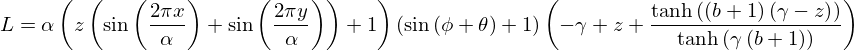


Absorption Coefficient


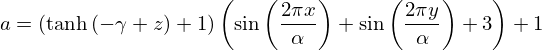


VSF


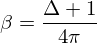

Boundary Condition



Source


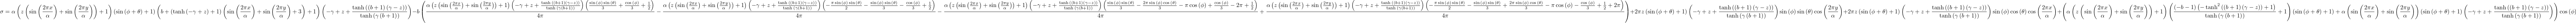

In [27]:
print("Solution")
mms.display_eq('L', sol_expr)
print()

print("Absorption Coefficient")
mms.display_eq('a', abs_expr)
print()

print("VSF")
mms.display_eq('beta', vsf_expr)

print("Boundary Condition")
mms.display_eq('L_0', bc_expr)
print()

print("Source")
mms.display_eq('sigma', source_expr)
print()

---

# Symbolic Analysis

## Check solution constraints

- Everything is periodic in x, y
- Absorption coefficient is positive
- Boundary condition depends only on angle
- No upwelling light from below
- Properly normalized VSF

In [28]:
# Check bottom BC
print('bottom:', sp.expand(sol_expr.subs('z',sp.Symbol('gamma'))) == 0)

# Check periodicity
smax = sp.Symbol('alpha')/2
smin = -smax
print('x:', sp.expand(sol_expr.subs('x',smax) - sol_expr.subs('x',smin)) == 0)
print('y:', sp.expand(sol_expr.subs('y',smax) - sol_expr.subs('y',smin)) == 0)

# Check VSF normalization (Should be 1 over whole sphere, or 1/(2pi) on [-1, 1].)
print(
    "VSF:",
    1 == sp.expand(
        mms.sphere_integral(
            vsf_expr.subs(
                'Delta', 
                mms.dot(
                    mms.vec_om, 
                    mms.vec_omp)
            ), 
            angle=mms.angle
        )
    )
)

bottom: True
x: True
y: True
VSF: True


## Check source term

If source term appears nonzero, try substituting parameters,
then plugging in analytical solution.

The result should be 0.

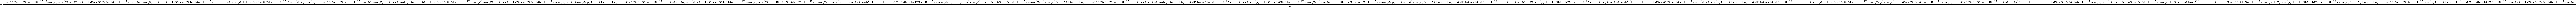

In [29]:
diff = mms.check_sol(sol_sym, b, abs_sym, vsf_sym, source_sym)
diff

In [30]:
num_diff = sp.lambdify(
    (*mms.space, *mms.angle),
    diff,
    modules=("numpy",)
)

In [31]:
# Check numerical max on grid in case of numerical error in above expression
np.max(num_diff(*mms.gen_grid(10, 10, 10, 10, 1, 1)))

## Examine solution dervatives

In [24]:
conv.max_derivs(sol_expr, rope_spacing, zmax, do_space=True, do_angle=True, **param_vals)

{'x': 1.413505298329503,
 'y': 1.413505298329503,
 'z': 3.6258993880023818,
 'theta': 0.4197979029529287,
 'phi': 0.4197979029529287}

In [25]:
conv.max_derivs(abs_expr, rope_spacing, zmax, do_space=True, do_angle=False, **param_vals)

{'x': 5.677129850288367, 'y': 5.677129850288367, 'z': 4.98752080385784}

In [26]:
conv.max_derivs(source_expr, rope_spacing, zmax, do_space=True, do_angle=True, **param_vals)

{'x': 13.096543106597515,
 'y': 11.812278884074438,
 'z': 27.663715828883845,
 'theta': 2.8344016108354273,
 'phi': 3.791281859537098}

---

# FD Verification

## IPyParallel Setup

In [32]:
#remote_config = kelp_param.ParamSpanRemoteConfig()
ipc = ipp.Client()
lv = ipc.load_balanced_view()
dv = ipc.direct_view()
print(ipc.ids)

[1]


/home/oliver/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@oliver-arch')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


In [33]:
ipc.queue_status()

{'unassigned': 0,
 0: {'queue': 0, 'completed': 5, 'tasks': 0},
 1: {'queue': 0, 'completed': 9, 'tasks': 0}}

## Single Space

### Compute

In [74]:
# base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
base_dir = '/home/oliver/academic/research/kelp-results'

na = 6

study_name = 'verify_ss_noscat_nofd_32x{}'.format(na)
study_dir = os.path.join(base_dir, study_name)

ns_list = [4, 8, 16, 32]
#ns_list = [4, 8, 12, 16, 20]

ntheta = na
nphi = na

# TODO: Don't actually delete results
#shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

num_scatters = 0
fd_flag = False

b = 0
param_vals['b'] = 0

combine_thread, gs_fut = kelp_compute.verify_single_space_compute(
    study_name, 
    ns_list, ntheta, nphi, 
    rope_spacing, zmax, b, 
    sol_expr, abs_expr, source_expr, bc_expr, vsf_expr,
    num_scatters, fd_flag,
    param_vals, base_dir=base_dir)

/home/oliver/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@oliver-arch')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


Creating new study directory.
Running grid ( 4, 4, 6, 6)
Running grid ( 8, 8, 6, 6)
Running grid (16,16, 6, 6)
Running grid (32,32, 6, 6)
Reading existing runs.
Finished reading existing runs.
Calling solve_rte_with_callbacks(4, 4, 6, 6, 1, 1, 0, alpha*(z*(sin(2*pi*x/alpha) + sin(2*pi*y/alpha)) + 1)*(sin(phi + theta) + 1)*(-gamma + z + tanh((b + 1)*(gamma - z))/tanh(gamma*(b + 1))), (tanh(-gamma + z) + 1)*(sin(2*pi*x/alpha) + sin(2*pi*y/alpha) + 3) + 1, alpha*(z*(sin(2*pi*x/alpha) + sin(2*pi*y/alpha)) + 1)*(sin(phi + theta) + 1)*(b + (tanh(-gamma + z) + 1)*(sin(2*pi*x/alpha) + sin(2*pi*y/alpha) + 3) + 1)*(-gamma + z + tanh((b + 1)*(gamma - z))/tanh(gamma*(b + 1))) - b*(alpha*(z*(sin(2*pi*x/alpha) + sin(2*pi*y/alpha)) + 1)*(-gamma + z + tanh((b + 1)*(gamma - z))/tanh(gamma*(b + 1)))*(sin(phi)*sin(theta)/3 + cos(phi)/3 + 1/2)/(4*pi) - alpha*(z*(sin(2*pi*x/alpha) + sin(2*pi*y/alpha)) + 1)*(-gamma + z + tanh((b + 1)*(gamma - z))/tanh(gamma*(b + 1)))*(-pi*sin(phi)*sin(theta)/2 - sin(phi)*si

Failed @ create_table with command: '
    CREATE TABLE verify_ss_noscat_nofd_32x6 (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        data_path CHAR(1024),
        b INTEGER,
        ns INTEGER,
        ntheta INTEGER,
        nphi INTEGER,
        nx INTEGER,
        ny INTEGER,
        nz INTEGER,
        nomega INTEGER,
        zmax INTEGER,
        rope_spacing INTEGER,
        num_scatters INTEGER,
        fd_flag INTEGER,
        lis_opts CHAR(1024),
        date CHAR(1024),
        git_commit CHAR(1024),
        compute_time REAL,
        lis_iter INTEGER,
        lis_time REAL,
        lis_resid REAL,
        sol_expr CHAR(1024),
        abs_expr CHAR(1024),
        source_expr CHAR(1024),
        bc_expr CHAR(1024),
        vsf_expr CHAR(1024),
        param_dict CHAR(1024)
    );'


### Plot

In [79]:
study_name = 'verify_ss_noscat_nofd_32x6'
study_dir = os.path.join(base_dir, study_name)

db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

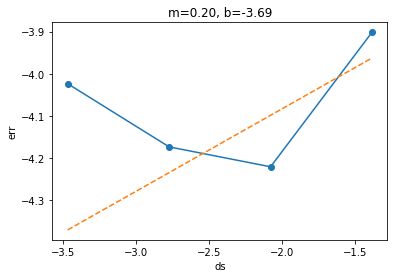

In [81]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
max_res_list = list(map(
    max,
    dim_resolutions
))
max_res_dict = {
    name: max_res
    for name, max_res in zip(dim_names, max_res_list)
}
dim_dict = dict(zip(dim_names, dim_resolutions))

ns_list = dim_dict['ns']

err_dict = {}
for ns in ns_list:
    results_list = kelp_analyze.query_results(
        conn, study_name,
        ns=ns,
        nz=ns,
    )

    rad = results_list[0]['rad'][:]
    true_rad = results_list[0]['true_rad'][:]

    err = norm(rad - true_rad)
    err_dict[ns] = err

res_arr = rope_spacing / np.array(ns_list)
err_arr = np.array([err_dict[ns] for ns in ns_list])

conv.plot_lin_fit(
    np.log(res_arr), np.log(err_arr), 
    min(np.log(res_arr))+.1, max(np.log(res_arr)), 
    xlabel='ds', ylabel='err'
)

## Multi-dimensional FD

### Compute

### Plot

In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
max_res_list = list(map(
    max,
    dim_resolutions
))
max_res_dict = {
    name: max_res
    for name, max_res in zip(dim_names, max_res_list)
}
dim_dict = dict(zip(dim_names, dim_resolutions))

# Loop over dimensions
for dim_num, dim_name in enumerate(dim_names):
    # List of resolutions in the current dimension
    current_dim = dim_dict[dim_name]
    
    print(dim_name)
    err_dict = {}
    for n in current_dim:
        all_dims = {**max_res_dict, **{dim_name: n}}
        results_list = kelp_analyze.query_results(
            conn, study_name, 
            **all_dims
        )

        rad = results_list[0]['rad'][:]
        true_rad = results_list[0]['true_rad'][:]

        err = norm(rad - true_rad)
        err_dict[n] = err

    res_arr = rope_spacing / np.array(current_dim)
    err_arr = np.array([err_dict[n] for n in current_dim])

    conv.plot_lin_fit(
        np.log(res_arr), np.log(err_arr), 
        min(np.log(res_arr)), max(np.log(res_arr)), 
        xlabel='d'+dim_name[1:], ylabel='err'
    )

# Asymptotics Verification

## Sourceless

### 1D, Uniform abs.

#### Compute

#### Plot

### 1D, Non-uniform abs,

#### Compute

#### Plot

## Full MMS

### Compute

In [97]:
# base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
base_dir = '/home/oliver/academic/research/kelp-results'

ns = 20
nz = 20
na = 6

num_scatters_list = [0, 1, 2]
b_list = np.logspace(-4, 2, 7)

study_name = 'verify_asym_{}x{}x{}_scat_0_1_2_b_m4_2'.format(ns, nz, na)
study_dir = os.path.join(base_dir, study_name)

ntheta = na
nphi = na

# TODO: Don't actually delete results
shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

combine_thread, gs_fut = kelp_compute.verify_asym_compute(
    study_name, 
    b_list, num_scatters_list,
    ns, nz, ntheta, nphi, 
    rope_spacing, zmax, 
    sol_expr, abs_expr, source_expr, bc_expr, vsf_expr,
    param_vals, base_dir=base_dir)

/home/oliver/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@oliver-arch')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


Creating new study directory.
Running asym.: (0.00,  0)
Running asym.: (0.00,  1)
Running asym.: (0.00,  2)
Running asym.: (0.00,  0)
Running asym.: (0.00,  1)
Running asym.: (0.00,  2)
Running asym.: (0.01,  0)
Running asym.: (0.01,  1)
Running asym.: (0.01,  2)
Running asym.: (0.10,  0)
Running asym.: (0.10,  1)
Running asym.: (0.10,  2)
Running asym.: (1.00,  0)
Running asym.: (1.00,  1)
Running asym.: (1.00,  2)
Running asym.: (10.00,  0)
Running asym.: (10.00,  1)
Running asym.: (10.00,  2)
Running asym.: (100.00,  0)
Running asym.: (100.00,  1)
Running asym.: (100.00,  2)
Reading existing runs.
Finished reading existing runs.
Calling solve_rte_with_callbacks(, study_dir='/home/oliver/academic/research/kelp-results/verify_asym_20x20x6_scat_0_1_2_b_m4_2', study_name='verify_asym_20x20x6_scat_0_1_2_b_m4_2', b=0.0001, num_scatters=0, param_dict={'alpha': 1, 'gamma': 1, 'b': 0.0001}, ns=20, nz=20, ntheta=6, nphi=6, rope_spacing=1, zmax=1, sol_expr=alpha*(z*(sin(2*pi*x/alpha) + sin(2*p

### Plot

In [102]:
study_name = 'verify_asym_20x20x6_scat_0_1_2_b_m4_2'
study_dir = os.path.join(base_dir, study_name)

In [103]:
db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

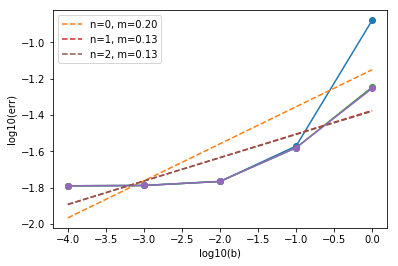

In [104]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

b_list, num_scatters_list = kelp_analyze.get_unique_vals(conn, study_name, ['b', 'num_scatters'])

for num_scatters in num_scatters_list:
    err_list = []
    for b in b_list:
        results_list = kelp_analyze.query_results(
            conn, study_name,
            b=b,
            num_scatters=num_scatters,
        )

        rad = results_list[0]['rad'][:]
        true_rad = results_list[0]['true_rad'][:]

        err = norm(rad - true_rad)
        err_list.append(err)

    b_arr = np.array(b_list)[:-2]
    err_arr = np.array(err_list)[:-2]
    
    conv.plot_lin_fit(
        np.log10(b_arr), np.log10(err_arr), 
        min(np.log(b_arr)), max(np.log(b_arr)), 
        xlabel='log10(b)', ylabel='log10(err)',
        label='n=%d, m={m:.2f}' % num_scatters
    )
    
    plt.title('')

plt.legend()